In [74]:
# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [75]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             classification_report, f1_score, accuracy_score,
                             precision_recall_curve, PrecisionRecallDisplay,
                             roc_curve, RocCurveDisplay, auc)
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

from datassist import experiment
from datassist import log_results

In [76]:
df_titanic = pd.read_csv('data/train.csv')
df_titanic = df_titanic.set_index('PassengerId')

## Preprocessing Pipeline

In [77]:
params = {
    'random_state': 42,
    'add_deck_from_cabin': True,
    'scale_SibSp_ParCh': 'SameAsNumeric',
}

In [78]:
if params['add_deck_from_cabin']:
    def take_first_letter(row):
        """Check if cabin is null and return the first letter of cabin"""
        if pd.isnull(row):
            return 'Unknown'
        else:
            return row[0]
    

    df_titanic['Deck'] = df_titanic['Cabin'].apply(take_first_letter)

In [79]:
# Dropping Name since it is not important for prediction,
# Cabin is also not useful since it has too many missing values.
# Finally, ticket is a random string of characters
X = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
y = df_titanic['Survived']

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=params['random_state'])

In [81]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
PassengerId,,,,,,,,
299,1,male,NaN,0,0,30.5000,S,C
885,3,male,25.00,0,0,7.0500,S,Unknown
248,2,female,24.00,0,2,14.5000,S,Unknown
479,3,male,22.00,0,0,7.5208,S,Unknown
306,1,male,0.92,1,2,151.5500,S,C


In [82]:
# Feature Engineering Steps
# imputer = SimpleImputer(strategy='median')
imputer = KNNImputer()
scaler = QuantileTransformer(
    output_distribution='normal',
    random_state=params['random_state'],
    n_quantiles=500
)
numeric_pipe = Pipeline((
    ('impute', imputer),
    ('scale', scaler),
))

# Categorical Encoder
categorical_encoder = OneHotEncoder()

# Identify Features
numeric_features = X.drop(columns=['SibSp', 'Parch']).select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

# Choose scaler for SibSp and Parch columns 
# to add to preproc_pipeline 
if params['scale_SibSp_ParCh'] == 'MinMaxScaler':
    remainder = MinMaxScaler((-1,1))
elif params['scale_SibSp_ParCh'] == 'SameAsNumeric':
    remainder = scaler
elif params['scale_SibSp_ParCh'] == 'None':
    remainder = 'passthrough'
else:
    raise ValueError(
        'scale_SibSp_ParCh must be one of "MinMaxScaler", "SameAsNumeric", or "None"'
    )

# Preprocessing pipeline
preproc_pipeline = ColumnTransformer(
    [
        ("numeric", numeric_pipe, numeric_features),
        ("categorical", categorical_encoder, categorical_features),
    ],
    # SibSp and ParCh will be passed through unchanged since
    # they are omitted from `numeric_features`
    remainder=remainder,
    n_jobs=-1
)

In [83]:
print(numeric_features)
print(categorical_features)

Index(['Pclass', 'Age', 'Fare'], dtype='object')
Index(['Sex', 'Embarked', 'Deck'], dtype='object')


In [84]:
# Check output from preproc_pipeline
transformed = preproc_pipeline.fit_transform(X_train)
transformed[:5, :]

array([[-5.19933758,  0.82597613,  0.67922709,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -5.19933758, -5.19933758],
       [ 5.19933758, -0.29560066, -1.76148522,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        , -5.19933758, -5.19933758],
       [-0.43256522, -0.43532485,  0.03517037,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        , -5.19933758,  1.553765  ],
       [ 5.19933758, -0.62638549, -1.29664163,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  

In [102]:
# check for NaNs in `transformed`
assert not np.isnan(transformed).any()

True

In [86]:
# Two NaNs in 'Embarked'
print(X_train['Sex'].unique())
print(X_train['Embarked'].unique())

['male' 'female']
['S' 'C' 'Q' nan]


In [87]:
# clf = LinearSVC(
#     random_state=params['random_state'],
#     # class_weight='balanced',
#     max_iter=2000
# )
clf = SVC(random_state=params['random_state'])
# clf2 = GradientBoostingClassifier(random_state=params['random_state'])
# clf3 = RandomForestClassifier(random_state=params['random_state'])

# clf = VotingClassifier(
#     estimators=[('svc', clf1), ('gbc', clf2), ('rfc', clf3)],
#     voting='hard'
# )

pipe = Pipeline((
    ('preprocessing', preproc_pipeline),
    ('classifier', clf)
))

## Results

In [88]:
# Evaluate using cross validation
cv_results = experiment.evaluate_cv(pipe, X_train, y_train, scoring='f1')
experiment.print_cv_results(cv_results, scoring='F1 score')

CV Results
F1 score: nan +/- nan
training time: 0.03s +/- 0.00s


In [99]:
for k,v in cv_results.items():
    print(k, ':', v)

fit_time : [0.03200102 0.03399897 0.03600025 0.03399968 0.03200054]
score_time : [0.01699877 0.01799893 0.01799917 0.01799917 0.01799965]
test_score : [       nan 0.69047619 0.80373832 0.72093023 0.63157895]


In [89]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

In [90]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       134
           1       0.83      0.67      0.75        89

    accuracy                           0.82       223
   macro avg       0.82      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



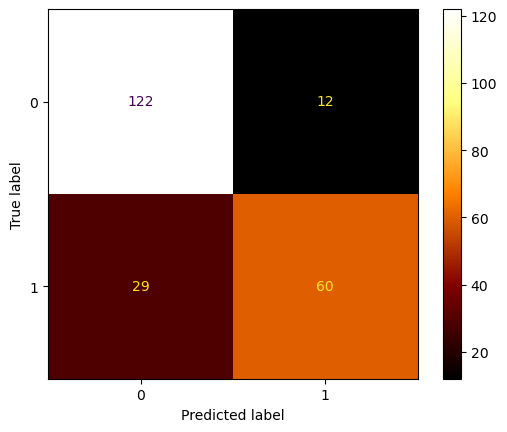

In [91]:
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display.im_.set_cmap('afmhot')

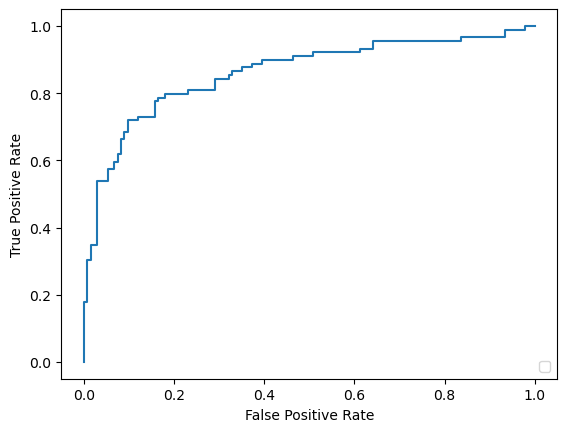

In [92]:
if hasattr(pipe, 'decision_function'):
    y_score = pipe.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=pipe.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [93]:
if hasattr(pipe, 'decision_function'):
    print(f'AUC score: {auc(fpr, tpr)}')

AUC score: 0.860724467549891


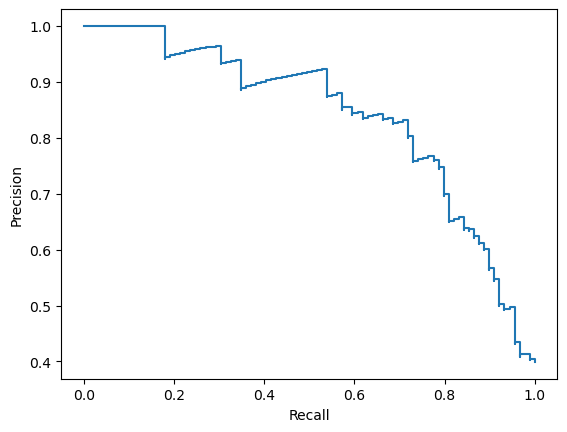

In [94]:
if hasattr(pipe, 'decision_function'):
    prec, recall, _ = precision_recall_curve(y_val, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## Log Results

In [95]:
metrics = {
    'F1_score': f1_score(y_val, y_pred),
    'Accuracy': accuracy_score(y_val, y_pred)
}
if hasattr(pipe, 'decision_function'):
    metrics['AUC'] = auc(fpr, tpr)

In [96]:
# Setup experiment logging
helper = log_results.MlflowHelper()
helper.start_local_tracking_server()
helper.setup_experiment('Titanic')

In [97]:
# Evaluate the model on the validation set
def log_model(
    model,
    params: dict | None,
    metrics: dict | None,
    tags: dict | None
):
    return model, params, metrics, tags

In [98]:
helper.run_experiment(
    lambda: log_model(pipe, params, metrics, None),
)

fluent 1
